In [316]:
# Project - Financial Data Analytics with Python
# Last Build date: 2022-8-15

# For debug use
import warnings
warnings.filterwarnings("ignore")

In [317]:
# Import required libraries
import datetime as dt
import pandas as pd
import numpy as np
# For download stock data
import yfinance as yf
# Prepare web scraping data from wikipedia
import bs4 as bs
import requests
# Prepare optimization
# Using efficient frontier and assigning weights (Optimization)
# Import required libraries
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
#from pypfopt.cla import CLA
#from pypfopt import plotting
#from matplotlib.ticker import FuncFormatter
# Quantstats library for html report
import quantstats as qs

In [318]:
# User custom values

# Data Source: File / Web 
# File: Get data from file (Run faster, select this if no internet connection)
# Web: Download live data using yfinance library (Require internet connection, not fully tested)
source = 'File' # (File / Web)
# Market stocks: Dow Jones Industrial Average (DJI) / S&P 100 (S&P100)
# Build portfolio using the stocks in that market index
stock_index = 'S&P100' # (DJI / S&P100)

# Portfolio options
# These are parameters to construct a new portfolio with optimization
# 1. Max Sharpe ratio
# 2. Min risk
# 3. Target risk
# 4. Target return

# Below is default one, feel free change to your values
start = dt.datetime(2019, 1, 1) # Back-test start date (must >= 2018-01-01)
end = dt.datetime(2022, 11, 30) # Back-test end date
capital = 10000 # Money will invest into portfolios
risk_free_rate = 0.02 # Risk free rate (%)
min_weight = 0.05 # Lower bound weighting used in optimization
max_weight = 1 # Upper bound weighting used in optimization
your_risk = 0 # Custom risk, useful if strategy = custom_risk
your_return = 0 # Custom return, useful if strategy = custom_return
strategy = 'max_sharpe' # (vaild options: max_sharpe / min_risk / custom_risk / custom_return)

In [319]:
# Get symbols from DJI wiki page
def get_DJI():
    if source == 'File':
        tickers = ['MMM','AXP','AMGN','AAPL','BA','CAT','CVX','CSCO','KO','DIS','DOW','GS','HD','HON','IBM','INTC','JNJ','JPM','MCD','MRK','MSFT','NKE','PG','CRM','TRV','UNH','VZ','V','WBA','WMT']
    else:
        #Web Scraping for the DJI Tickers
        resp = requests.get('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
        soup = bs.BeautifulSoup(resp.text, 'lxml')
        table = soup.find('table', {'class' : 'wikitable sortable'}) # table class name is wikitable sortable
        tickers = []
        for row in table.findAll('tr')[1:]:   #Table row
            ticker = row.findAll('td')[1].text.replace('\n','')   #Table data
            ticker = ticker.split(':\xa0')
            if len(ticker) > 1:
                tickers.append(ticker[1])
            else:
                tickers.append(ticker[0])
    return tickers

In [320]:
# Or get symbols from S&P100, if your favourite stocks not in DJI, you can use this ticker list
def get_sp100():
    if source == 'File':
        tickers = ['AAPL','ABBV','ABT','ACN','ADBE','AIG','AMGN','AMT','AMZN','AVGO','AXP','BA','BAC','BK','BKNG','BLK','BMY','BRK-B','C','CAT','CHTR','CL','CMCSA','COF','COP','COST','CRM','CSCO','CVS','CVX','DD','DHR','DIS','DOW','DUK','EMR','EXC','F','FDX','GD','GE','GILD','GM','GOOG','GOOGL','GS','HD','HON','IBM','INTC','JNJ','JPM','KHC','KO','LIN','LLY','LMT','LOW','MA','MCD','MDLZ','MDT','MET','META','MMM','MO','MRK','MS','MSFT','NEE','NFLX','NKE','NVDA','ORCL','PEP','PFE','PG','PM','PYPL','QCOM','RTX','SBUX','SCHW','SO','SPG','T','TGT','TMO','TMUS','TSLA','TXN','UNH','UNP','UPS','USB','V','VZ','WBA','WFC','WMT','XOM']
    else:
        # URL request, URL opener, read content
        resp = requests.get('https://en.wikipedia.org/wiki/S%26P_100')
        soup = bs.BeautifulSoup(resp.text, 'lxml')
        table = soup.find('table', {'class' : 'wikitable sortable'}) # table class name is wikitable sortable
        tickers = []
        for row in table.findAll('tr')[1:]:   #Table row
            ticker = row.findAll('td')[0].text.replace('\n','')   #Table data
            ticker = ticker.split(':\xa0')
            if len(ticker) > 1:
                tickers.append(ticker[1])
            else:
                tickers.append(ticker[0])
        tickers = list(map(lambda x: x.replace('.', '-'), tickers)) # For yahoo finance compatibility
    return tickers

In [321]:
# Use DJI to build small model for testing, then use SP100 to build larger one later

if stock_index == 'DJI':
    tickers = get_DJI()
else:
    tickers = get_sp100()

In [322]:
# Get data from Yahoo finance, specify the start and end date in {start} and {end} variables
''' Downloading Historical Stock Data from market '''
stock_data = pd.DataFrame()

if source == 'File':
    if stock_index == 'DJI':
        stock_data = pd.read_csv('dji_data_monthly.csv', index_col=['Date'])
    elif stock_index == 'S&P100':
        stock_data = pd.read_csv('sp100_data_monthly.csv', index_col=['Date'])
    # Data preparation
    #stock_data.set_index(pd.to_datetime(stock_data['Date'], format='%Y-%m-%d %H:%M:%S%z'), inplace=True)#, format='%Y-%m-%d')
    #stock_data = stock_data.set_index(dt.datetime.strptime(stock_data['Date'], '%Y-%m-%d %H:%M:%S%z'))
    #stock_data = stock_data.tz_localize(None)  
    # Convert datetimeindex to utc
    stock_data.index = pd.to_datetime(stock_data.index, utc=True)
    stock_data = stock_data[start:end]
else:
    for stock in tickers:
        print(f'Downloading stock data for {stock}', end='')
        tickerData = yf.Ticker(stock)
        tickerCl = tickerData.history(interval='1mo', start=start, end=end)['Close']
        stock_data[stock] = tickerCl
        print(f'......OK!')
    # Data preparation
    stock_data = stock_data.dropna(how='all')
    stock_data['DOW'] = stock_data['DOW'].fillna(value=stock_data['DOW'].mean()) # Fill NA values since DOW start from 2019-04
    # Convert datetimeindex to utc
    stock_data.index = pd.to_datetime(stock_data.index, utc=True)


In [323]:
stock_data.head()
#stock_data.to_csv('sp100_data_monthly1.csv')

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 05:00:00+00:00,40.160965,66.136475,68.450661,145.435043,247.820007,38.751980,24.410000,167.297470,160.432129,85.936501,...,255.305038,147.052063,93.382362,44.733837,131.519669,45.903366,62.489586,43.573765,89.869484,59.151997
2019-02-01 05:00:00+00:00,41.780033,66.072113,73.140297,152.851288,262.500000,38.725090,23.530001,169.952957,163.504517,81.991501,...,228.867462,155.030060,97.635071,45.197266,144.290726,47.949299,61.564266,44.849762,92.832916,63.793442
2019-03-01 05:00:00+00:00,46.030354,67.197769,75.326393,166.717545,266.489990,38.599586,25.520000,171.176971,182.913422,89.037498,...,233.629608,155.371399,99.868225,42.136887,152.417679,49.810997,55.049557,43.438374,91.463737,65.946312
2019-04-01 04:00:00+00:00,48.628124,66.197189,74.968323,173.016129,289.250000,42.956329,27.629999,161.572021,181.279785,96.325996,...,221.062424,164.515274,94.934700,46.983707,160.458618,48.176743,46.609848,43.519276,96.962387,65.521889
2019-05-01 04:00:00+00:00,42.424507,64.810616,72.029861,170.056198,270.899994,46.116863,27.410000,150.201050,194.673431,88.753502,...,229.342651,154.981110,83.047760,44.234474,157.433517,46.256050,42.929428,39.887428,95.642410,57.760136


In [324]:
# Convert the stock price to return using pct_change() function
''' Calculating the monthly returns of all DJI Stocks '''
#stock_returns = pd.DataFrame()

#for stock in tickers:
#    stock_returns[stock] = stock_data[stock].pct_change().dropna()

stock_returns = stock_data.pct_change().dropna()
stock_returns.head()

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2019-02-01 05:00:00+00:00,0.040314,-0.000973,0.068511,0.050994,0.059237,-0.000694,-0.036051,0.015873,0.019151,-0.045906,...,-0.103553,0.054253,0.045541,0.010360,0.097104,0.044570,-0.014808,0.029284,0.032975,0.078466
2019-03-01 05:00:00+00:00,0.101731,0.017037,0.029889,0.090717,0.015200,-0.003241,0.084573,0.007202,0.118706,0.085936,...,0.020807,0.002202,0.022872,-0.067712,0.056323,0.038826,-0.105820,-0.031469,-0.014749,0.033748
2019-04-01 04:00:00+00:00,0.056436,-0.014890,-0.004754,0.037780,0.085407,0.112870,0.082680,-0.056111,-0.008931,0.081859,...,-0.053791,0.058852,-0.049400,0.115026,0.052756,-0.032809,-0.153311,0.001862,0.060118,-0.006436
2019-05-01 04:00:00+00:00,-0.127573,-0.020946,-0.039196,-0.017108,-0.063440,0.073576,-0.007962,-0.070377,0.073884,-0.078613,...,0.037457,-0.057953,-0.125212,-0.058515,-0.018853,-0.039868,-0.078962,-0.083454,-0.013613,-0.118460
2019-06-01 04:00:00+00:00,0.134873,-0.052014,0.104690,0.037625,0.087671,0.043274,0.107990,0.114977,-0.020693,0.066792,...,0.009140,0.019278,0.122018,0.043825,0.077400,0.051150,0.117391,0.076796,0.095001,0.095215


In [325]:
# Prepare historial data for optimization algorithm use
from datetime import timedelta
    
start_hist = start - timedelta(days=365) # 1 yr before the analysis date

stock_daily_data = pd.DataFrame()
if source == 'File':
    if stock_index == 'DJI':
        stock_daily_data = pd.read_csv('dji_data_daily.csv', index_col=['Date'])
    elif stock_index == 'S&P100':
        stock_daily_data = pd.read_csv('sp100_data_daily.csv', index_col=['Date'])
    # Data preparation
    #stock_daily_data['Date'] = pd.to_datetime(stock_daily_data['Date'], format='%Y-%m-%d')
    #stock_daily_data = stock_daily_data.set_index('Date')
    # Convert datetimeindex to utc
    stock_daily_data.index = pd.to_datetime(stock_daily_data.index, utc=True)
    stock_daily_data = stock_daily_data[start_hist:]
else:    
    for stock in tickers:
        print(f'Downloading stock data for {stock}', end='')
        tickerData = yf.Ticker(stock)
        tickerCl = tickerData.history(interval='1d', start=start_hist, end=end)['Close']
        stock_daily_data[stock] = tickerCl
        print(f'......OK!')
    # Data preparation    
    stock_daily_data['DOW'] = stock_daily_data['DOW'].fillna(value=stock_daily_data['DOW'].mean()) # Fill NA values since DOW start from 2019-04
    # Convert datetimeindex to utc
    stock_daily_data.index = pd.to_datetime(stock_daily_data.index, utc=True)


In [326]:
# Check data ok?
stock_daily_data.head()
#stock_daily_data.to_csv('dji_data_daily1.csv')

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 05:00:00+00:00,40.950497,78.019859,54.148956,143.127075,177.699997,51.953159,10.98,153.740326,128.172165,59.450500,...,206.187897,122.919281,106.109169,45.978516,110.811302,42.605366,63.297535,52.879997,90.314163,65.905403
2018-01-03 05:00:00+00:00,40.943359,79.240768,54.268688,143.787613,181.039993,52.529442,11.55,156.641464,128.671631,60.209999,...,208.350815,123.607307,108.460075,46.429535,111.914482,41.729862,63.770466,53.286827,91.101982,67.199791
2018-01-04 05:00:00+00:00,41.133537,78.788887,54.176582,145.490143,183.220001,52.739006,12.12,155.981339,126.791695,60.479500,...,209.255127,122.937378,109.163643,46.786942,112.330566,41.865158,60.468353,53.953354,91.184441,67.292816
2018-01-05 05:00:00+00:00,41.601852,80.160423,54.333168,146.690353,185.339996,52.957291,11.88,156.910721,127.609077,61.457001,...,213.245392,124.503510,109.498253,47.076286,115.020760,41.769661,61.583141,54.316917,91.724907,67.238525
2018-01-08 05:00:00+00:00,41.447350,78.876060,54.176582,147.862564,185.039993,52.608032,12.28,156.867325,128.971359,62.343498,...,209.544159,126.232628,110.828156,47.144360,115.485268,41.698029,62.368546,53.702332,93.080681,67.540817


In [327]:
# Try to compare above strategies to market index itself
# Get market data (use same date range as our portfolio)
index_data = pd.DataFrame()
if source == 'File':
    if stock_index == 'DJI':
        index_data = pd.read_csv('dji_index_monthly.csv', index_col=['Date'])
    elif stock_index == 'S&P100':
        index_data = pd.read_csv('sp100_index_monthly.csv', index_col=['Date'])
    #index_data['Date'] = pd.to_datetime(index_data['Date'], format='%Y-%m-%d')
    #index_data = index_data.set_index('Date')
    # Convert datetimeindex to utc
    index_data.index = pd.to_datetime(index_data.index, utc=True)
    index_data = index_data[start:end]
else:
    if stock_index == 'DJI':
        mkt_ticker = yf.Ticker('^DJI')
    elif stock_index == 'S&P100':
        mkt_ticker = yf.Ticker('^OEX')
    tickerCl = mkt_ticker.history(interval='1mo', start=start, end=end)['Close']
    index_data['Close'] = tickerCl
    # Convert datetimeindex to utc
    index_data.index = pd.to_datetime(index_data.index, utc=True)

In [328]:
# Check data
index_data.head()

,Close
Date,
2019-01-01 05:00:00+00:00,1191.680054
2019-02-01 05:00:00+00:00,1223.550049
2019-03-01 05:00:00+00:00,1251.560059
2019-04-01 04:00:00+00:00,1305.199951
2019-05-01 04:00:00+00:00,1215.020020


In [329]:
# Get return from market index

''' Calculating the KPIs for the market Index over the same period '''
index_data['Return'] = index_data.pct_change()
index_data.dropna(inplace = True)

In [330]:
index_data.head()

,Close,Return
Date,,
2019-02-01 05:00:00+00:00,1223.550049,0.026744
2019-03-01 05:00:00+00:00,1251.560059,0.022892
2019-04-01 04:00:00+00:00,1305.199951,0.042858
2019-05-01 04:00:00+00:00,1215.020020,-0.069093
2019-06-01 04:00:00+00:00,1297.459961,0.067851


In [331]:
# For portfolio performance KPI calculation
def volatility(stock_data):
    ''' Calculate the Annualized Volatility of a Trading Strategy '''
    volatility = stock_data['Return'].std() * np.sqrt(12)
    
    return volatility

In [332]:
def CAGR(stock_data):
    ''' Calculate the Compound Annual Growth Rate of a Trading Strategy '''
    stock_data['Cumulative_Return'] = (1 + stock_data['Return']).cumprod()
    years = len(stock_data) / 12
    carg = stock_data['Cumulative_Return'].tolist()[-1] ** (1/years) - 1
    
    return carg

In [333]:
def sharpe_ratio(stock_data, risk_free):
    ''' Calculate the Sharpe Ratio of a Portfolio '''
    sharpe = (CAGR(stock_data) - risk_free) / volatility(stock_data)
    
    return sharpe

In [334]:
def pf_performance(portfolio):
    print(f'The Compound Annual Growth Rate is {round(CAGR(portfolio)*100,2)}%')
    print(f'The Portfolio Volality is {round(volatility(portfolio)*100,2)}%')
    print(f'The Sharpe Ratio is {round(sharpe_ratio(portfolio, risk_free_rate),2)}')

In [335]:
# Add new function, assign weights parameters in return calculation (optimization using max sharpe ratio) 

def pf_weights(pf):
    pf_hist = stock_daily_data[pf].loc[:start] # Get stocks price 1 year before the portfolio build date for optimization
    
    #Annualized Return
    mu = expected_returns.mean_historical_return(pf_hist)
    #Sample Variance of Portfolio
    Sigma = risk_models.sample_cov(pf_hist)
    
    #Max Sharpe Ratio - Tangent to the EF
    ef = EfficientFrontier(mu, Sigma, weight_bounds=(min_weight, max_weight))
    #ef.add_objective(objective_functions.L2_reg, gamma=2)
    # Check if the return can apply optimization, otherwise equally distribute the stocks (or try alternative strategy?)
    try:
        if strategy == 'max_sharpe':
            ef.max_sharpe(risk_free_rate=risk_free_rate)
        elif strategy == 'min_risk':
            ef.min_volatility()
        elif strategy == 'custom_risk' and your_risk.replace('.','',1).isdigit():
            ef.efficient_risk(your_risk)
        elif strategy == 'custom_return' and your_return.replace('.','',1).isdigit():
            ef.efficient_return(your_return)
        weights = ef.clean_weights()
    except Exception:
        wt = 1/len(pf)
        weights = dict.fromkeys(pf, wt)
        ef.set_weights(weights)
        
    # print(weights) #DEBUG
    # Convert from dict to dataframe
    weights_df = pd.DataFrame.from_dict(weights, orient = 'index')
    weights_df.columns = ['weights']
    expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance(risk_free_rate=risk_free_rate)
    weights_df['sharpe'] = sharpe_ratio
    weights_df['yr_return'] = expected_annual_return
    weights_df['yr_risk'] = annual_volatility
    return weights_df

In [336]:
# Strategy 1 - Remove n stocks if their return is worse than other stocks in portfolio 
def portfolio(dataframe, n_stocks, n_remove):
    '''
    dataframe: Dataframe with the stocks returns
    n_stocks: Number of stocks to be selected in the portfolio
    n_remove: Number of bad stocks to be remove in the portfolio
    '''
    portfolio = []
    weekly_return = [0]
    # For export to csv
    df_date = []
    df_portfolio = []
    df_returns = []
    for i in range(1, len(dataframe)):
        if len(portfolio) > 0:
            weekly_return.append(dataframe[portfolio].iloc[i, :].mean())
            negative_stocks = dataframe[portfolio].iloc[i, :].sort_values(ascending=True)[: n_remove].index.tolist()
            portfolio = [stock for stock in portfolio if stock not in negative_stocks]
        to_fill = n_stocks - len(portfolio)
        new_stocks = dataframe.iloc[i,:].sort_values(ascending=False)[:n_stocks].index.tolist()
        new_stocks = [stock for stock in new_stocks if stock not in portfolio][:to_fill] #We make sure to not repeat stocks in the portfolio
        portfolio = portfolio + new_stocks
        df_date.append(dataframe.index[i])
        df_portfolio.append(','.join(portfolio))
        df_returns.append(weekly_return[-1])
        print(f'({dataframe.index[i].strftime("%Y-%m-%d")}) The monthly portfolio selected is {portfolio}')
  
    portfolio_ret = pd.DataFrame(np.array(weekly_return), columns = ['Return'])
    df_exported = pd.DataFrame(df_portfolio, index=df_date, columns=['Portfolio'])
    df_exported['Return'] = df_returns
    return portfolio_ret, df_exported

In [337]:
# Total x stocks in the portfolio and remove y worst stocks every monthly
# Usage: portfolio(return (dataframe), x (numeric), y (numeric))

s1_portfolio, s1_export  = portfolio(stock_returns, 8, 3)

(2019-03-01) The monthly portfolio selected is ['NVDA', 'AMT', 'TGT', 'COST', 'AAPL', 'MO', 'AVGO', 'ACN']
(2019-04-01) The monthly portfolio selected is ['NVDA', 'COST', 'AAPL', 'AVGO', 'ACN', 'QCOM', 'DIS', 'F']
(2019-05-01) The monthly portfolio selected is ['COST', 'AAPL', 'ACN', 'DIS', 'F', 'AMT', 'AIG', 'MDT']
(2019-06-01) The monthly portfolio selected is ['COST', 'AAPL', 'DIS', 'F', 'MDT', 'NVDA', 'TSLA', 'GM']
(2019-07-01) The monthly portfolio selected is ['COST', 'AAPL', 'MDT', 'TSLA', 'GM', 'UPS', 'SBUX', 'GOOG']
(2019-08-01) The monthly portfolio selected is ['COST', 'AAPL', 'MDT', 'UPS', 'SBUX', 'TGT', 'AMGN', 'LOW']
(2019-09-01) The monthly portfolio selected is ['AAPL', 'MDT', 'UPS', 'TGT', 'LOW', 'ABBV', 'DOW', 'EMR']
(2019-10-01) The monthly portfolio selected is ['AAPL', 'LOW', 'ABBV', 'DOW', 'EMR', 'TSLA', 'AMD', 'UNH']
(2019-11-01) The monthly portfolio selected is ['AAPL', 'ABBV', 'DOW', 'AMD', 'UNH', 'SCHW', 'TGT', 'DIS']
(2019-12-01) The monthly portfolio select

In [338]:
s1_export.head()

,Portfolio,Return
2019-03-01 05:00:00+00:00,"NVDA,AMT,TGT,COST,AAPL,MO,AVGO,ACN",0.000000
2019-04-01 04:00:00+00:00,"NVDA,COST,AAPL,AVGO,ACN,QCOM,DIS,F",0.012464
2019-05-01 04:00:00+00:00,"COST,AAPL,ACN,DIS,F,AMT,AIG,MDT",-0.120595
2019-06-01 04:00:00+00:00,"COST,AAPL,DIS,F,MDT,NVDA,TSLA,GM",0.060646
2019-07-01 04:00:00+00:00,"COST,AAPL,MDT,TSLA,GM,UPS,SBUX,GOOG",0.036076


In [339]:
# Calculation the performance of Strategy 1
pf_performance(s1_portfolio)

The Compound Annual Growth Rate is 29.59%
The Portfolio Volality is 23.94%
The Sharpe Ratio is 1.15


In [340]:
# Strategy 2 - Random select n stocks into the portfolio
def portfolio_random(dataframe, n_stocks):
    '''
    dataframe: Dataframe with the stocks returns
    n_stocks: Number of stocks to be selected in the portfolio
    n_remove: Number of bad stocks to be remove in the portfolio
    '''
    portfolio = []
    weekly_return = [0]
    # For export to csv
    df_date = []
    df_portfolio = []
    df_returns = []
    for i in range(1, len(dataframe)):
        if len(portfolio) > 0:
            weekly_return.append(portfolio.iloc[i, :].mean())
        portfolio = dataframe.sample(n=n_stocks, axis='columns')
        df_date.append(dataframe.index[i])
        df_portfolio.append(','.join(list(portfolio.columns)))
        df_returns.append(weekly_return[-1])
        print(f'({dataframe.index[i].strftime("%Y-%m-%d")}) The monthly portfolio selected is {list(portfolio.columns)}')
  
    portfolio_ret = pd.DataFrame(np.array(weekly_return), columns = ['Return'])
    df_exported = pd.DataFrame(df_portfolio, index=df_date, columns=['Portfolio'])
    df_exported['Return'] = df_returns
    return portfolio_ret, df_exported

In [341]:
s2_portfolio, s2_export  = portfolio_random(stock_returns, 8)

(2019-03-01) The monthly portfolio selected is ['CVS', 'AXP', 'CSCO', 'FDX', 'BLK', 'AMD', 'CVX', 'RTX']
(2019-04-01) The monthly portfolio selected is ['PM', 'KHC', 'SCHW', 'UNH', 'INTC', 'FDX', 'IBM', 'PEP']
(2019-05-01) The monthly portfolio selected is ['LOW', 'GOOGL', 'NFLX', 'WBA', 'MS', 'LLY', 'CVX', 'F']
(2019-06-01) The monthly portfolio selected is ['BKNG', 'MET', 'CVS', 'PEP', 'BLK', 'AMT', 'GOOGL', 'AXP']
(2019-07-01) The monthly portfolio selected is ['AMT', 'COF', 'PG', 'SO', 'AMD', 'BKNG', 'BLK', 'GOOGL']
(2019-08-01) The monthly portfolio selected is ['AMD', 'V', 'ORCL', 'USB', 'TGT', 'MA', 'BKNG', 'LMT']
(2019-09-01) The monthly portfolio selected is ['MDT', 'SBUX', 'GE', 'COF', 'NVDA', 'TSLA', 'COST', 'NKE']
(2019-10-01) The monthly portfolio selected is ['AAPL', 'EXC', 'C', 'KO', 'AIG', 'AXP', 'MDT', 'CSCO']
(2019-11-01) The monthly portfolio selected is ['PYPL', 'AAPL', 'ADBE', 'PFE', 'CAT', 'MO', 'LOW', 'ACN']
(2019-12-01) The monthly portfolio selected is ['BLK', 

In [342]:
s2_export.head()

,Portfolio,Return
2019-03-01 05:00:00+00:00,"CVS,AXP,CSCO,FDX,BLK,AMD,CVX,RTX",0.000000
2019-04-01 04:00:00+00:00,"PM,KHC,SCHW,UNH,INTC,FDX,IBM,PEP",0.059170
2019-05-01 04:00:00+00:00,"LOW,GOOGL,NFLX,WBA,MS,LLY,CVX,F",-0.093580
2019-06-01 04:00:00+00:00,"BKNG,MET,CVS,PEP,BLK,AMT,GOOGL,AXP",0.057971
2019-07-01 04:00:00+00:00,"AMT,COF,PG,SO,AMD,BKNG,BLK,GOOGL",0.023094


In [343]:
# Calculation the performance of Strategy 2
pf_performance(s2_portfolio)

The Compound Annual Growth Rate is 10.97%
The Portfolio Volality is 22.16%
The Sharpe Ratio is 0.4


In [344]:
# Strategy 1A - Based on strategy 1 (remove n worse stocks) and optimized using Efficient frontier
def portfolio_optimized(dataframe, n_stocks, n_remove):
    '''
    dataframe: Dataframe with the stocks returns
    n_stocks: Number of stocks to be selected in the portfolio
    n_remove: Number of bad stocks to be remove in the portfolio
    '''
    portfolio = []
    weekly_return = [0]
    total_return = [0]
    weekly_sharpe = []
    yr_return = []
    yr_risk = []
    # For export to csv
    df_date = []
    df_portfolio = []
    df_returns = []
    #for i in range(1, 10):
    for i in range(1, len(dataframe)):
        if len(portfolio) > 0:
            weekly_return.append(np.dot(dataframe[portfolio].iloc[i, :], weights))
            negative_stocks = dataframe[portfolio].iloc[i, :].sort_values(ascending=True)[: n_remove].index.tolist()
            portfolio = [stock for stock in portfolio if stock not in negative_stocks]
        to_fill = n_stocks - len(portfolio)
        new_stocks = dataframe.iloc[i,:].sort_values(ascending=False)[:n_stocks].index.tolist()
        new_stocks = [stock for stock in new_stocks if stock not in portfolio][:to_fill] #We make sure to not repeat stocks in the portfolio
        portfolio = portfolio + new_stocks
        pf_wt = pf_weights(portfolio)
        weights = pf_wt['weights']
        sharpe = pf_wt['sharpe'][0]
        weekly_sharpe.append(sharpe)
        yr_return.append(pf_wt['yr_return'][0])
        yr_risk.append(pf_wt['yr_risk'][0])
        df_date.append(dataframe.index[i])
        df_portfolio.append(','.join(portfolio))
        df_returns.append(weekly_return[-1])
        print(f'({dataframe.index[i].strftime("%Y-%m-%d")}) The monthly portfolio selected is {portfolio}, weights is {weights.values.tolist()}, sharpe is {round(sharpe,2)}')
  

    portfolio_ret = pd.DataFrame(np.array(weekly_return), columns = ['Return'])
    portfolio_ret['sharpe'] = pd.DataFrame(np.array(weekly_sharpe))
    portfolio_ret['yr_return'] = pd.DataFrame(np.array(yr_return))
    portfolio_ret['yr_risk'] = pd.DataFrame(np.array(yr_risk))
    df_exported = pd.DataFrame(df_portfolio, index=df_date, columns=['Portfolio'])
    df_exported['Return'] = df_returns
    
    return portfolio_ret, df_exported

In [345]:
s1a_portfolio, s1a_export = portfolio_optimized(stock_returns, 8, 3)

(2019-03-01) The monthly portfolio selected is ['NVDA', 'AMT', 'TGT', 'COST', 'AAPL', 'MO', 'AVGO', 'ACN'], weights is [0.05, 0.65, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], sharpe is 0.26
(2019-04-01) The monthly portfolio selected is ['NVDA', 'COST', 'AAPL', 'AVGO', 'ACN', 'QCOM', 'DIS', 'F'], weights is [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], sharpe is -0.59
(2019-05-01) The monthly portfolio selected is ['COST', 'AAPL', 'ACN', 'DIS', 'F', 'AMT', 'AIG', 'MDT'], weights is [0.05, 0.05, 0.05, 0.05, 0.05, 0.57365, 0.05, 0.12635], sharpe is 0.28
(2019-06-01) The monthly portfolio selected is ['COST', 'AAPL', 'DIS', 'F', 'MDT', 'NVDA', 'TSLA', 'GM'], weights is [0.05, 0.05, 0.05, 0.05, 0.65, 0.05, 0.05, 0.05], sharpe is 0.12
(2019-07-01) The monthly portfolio selected is ['COST', 'AAPL', 'MDT', 'TSLA', 'GM', 'UPS', 'SBUX', 'GOOG'], weights is [0.05, 0.05, 0.24989, 0.05, 0.05, 0.05, 0.45011, 0.05], sharpe is 0.34
(2019-08-01) The monthly portfolio selected is ['COST', 'AAPL',

In [346]:
s1a_export.head()

,Portfolio,Return
2019-03-01 05:00:00+00:00,"NVDA,AMT,TGT,COST,AAPL,MO,AVGO,ACN",0.000000
2019-04-01 04:00:00+00:00,"NVDA,COST,AAPL,AVGO,ACN,QCOM,DIS,F",-0.000373
2019-05-01 04:00:00+00:00,"COST,AAPL,ACN,DIS,F,AMT,AIG,MDT",-0.120595
2019-06-01 04:00:00+00:00,"COST,AAPL,DIS,F,MDT,NVDA,TSLA,GM",0.017389
2019-07-01 04:00:00+00:00,"COST,AAPL,MDT,TSLA,GM,UPS,SBUX,GOOG",0.042462


In [347]:
# Calculation the performance of Strategy 1A
pf_performance(s1a_portfolio)

The Compound Annual Growth Rate is 30.55%
The Portfolio Volality is 24.78%
The Sharpe Ratio is 1.15


In [348]:
# Strategy 2A - Based on strategy 2 (random picker) and optimized using Efficient frontier

def portfolio_random_optimized(dataframe, n_stocks):
    '''
    dataframe: Dataframe with the stocks returns
    n_stocks: Number of stocks to be selected in the portfolio
    n_remove: Number of bad stocks to be remove in the portfolio
    '''
    portfolio = []
    weekly_return = [0]
    total_return = [0]
    weekly_sharpe = []
    yr_return = []
    yr_risk = []
    # For export to csv
    df_date = []
    df_portfolio = []
    df_returns = []
    #for i in range(1, 10):
    for i in range(1, len(dataframe)):
        if len(portfolio) > 0:
            weekly_return.append(np.dot(portfolio.iloc[i, :],weights))
        portfolio = dataframe.sample(n=n_stocks, axis='columns')
        pf_wt = pf_weights(portfolio.columns)
        weights = pf_wt['weights']
        sharpe = pf_wt['sharpe'][0]
        weekly_sharpe.append(sharpe)
        yr_return.append(pf_wt['yr_return'][0])
        yr_risk.append(pf_wt['yr_risk'][0])
        df_date.append(dataframe.index[i])
        df_portfolio.append(','.join(list(portfolio.columns)))
        df_returns.append(weekly_return[-1])
        print(f'({stock_returns.index[i].strftime("%Y-%m-%d")}) The monthly portfolio selected is {list(portfolio.columns)}, weights is {weights.values.tolist()}, sharpe is {round(sharpe,2)}')
  

    portfolio_ret = pd.DataFrame(np.array(weekly_return), columns = ['Return'])
    portfolio_ret['sharpe'] = pd.DataFrame(np.array(weekly_sharpe))
    portfolio_ret['yr_return'] = pd.DataFrame(np.array(yr_return))
    portfolio_ret['yr_risk'] = pd.DataFrame(np.array(yr_risk))
    df_exported = pd.DataFrame(df_portfolio, index=df_date, columns=['Portfolio'])
    df_exported['Return'] = df_returns
    
    return portfolio_ret, df_exported

In [349]:
s2a_portfolio, s2a_export = portfolio_random_optimized(stock_returns, 8)

(2019-03-01) The monthly portfolio selected is ['AMGN', 'LMT', 'MET', 'AVGO', 'AMT', 'GE', 'MA', 'COP'], weights is [0.05, 0.05, 0.05, 0.05, 0.13604, 0.05, 0.56396, 0.05], sharpe is 0.53
(2019-04-01) The monthly portfolio selected is ['VZ', 'BMY', 'MDLZ', 'UPS', 'MDT', 'USB', 'BRK-B', 'IBM'], weights is [0.05, 0.05, 0.05, 0.05, 0.65, 0.05, 0.05, 0.05], sharpe is 0.2
(2019-05-01) The monthly portfolio selected is ['PM', 'PEP', 'UNH', 'CHTR', 'V', 'AMGN', 'GM', 'AIG'], weights is [0.05, 0.05, 0.07488, 0.05, 0.62512, 0.05, 0.05, 0.05], sharpe is 0.23
(2019-06-01) The monthly portfolio selected is ['CAT', 'GD', 'GS', 'PFE', 'HD', 'KHC', 'COST', 'LLY'], weights is [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.65], sharpe is 1.04
(2019-07-01) The monthly portfolio selected is ['UPS', 'PM', 'BLK', 'CVX', 'KO', 'TMO', 'LIN', 'UNP'], weights is [0.05, 0.05, 0.05, 0.05, 0.05, 0.65, 0.05, 0.05], sharpe is 0.26
(2019-08-01) The monthly portfolio selected is ['AMGN', 'INTC', 'PYPL', 'XOM', 'UNP', 'L

(2022-11-11) The monthly portfolio selected is ['BLK', 'PFE', 'KHC', 'AMGN', 'MET', 'CVS', 'COF', 'TXN'], weights is [0.05, 0.65, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], sharpe is 0.47


In [350]:
s2a_export.head()

,Portfolio,Return
2019-03-01 05:00:00+00:00,"AMGN,LMT,MET,AVGO,AMT,GE,MA,COP",0.000000
2019-04-01 04:00:00+00:00,"VZ,BMY,MDLZ,UPS,MDT,USB,BRK-B,IBM",0.052350
2019-05-01 04:00:00+00:00,"PM,PEP,UNH,CHTR,V,AMGN,GM,AIG",0.006518
2019-06-01 04:00:00+00:00,"CAT,GD,GS,PFE,HD,KHC,COST,LLY",0.069334
2019-07-01 04:00:00+00:00,"UPS,PM,BLK,CVX,KO,TMO,LIN,UNP",-0.007284


In [351]:
# Calculation the performance of Strategy 2
pf_performance(s2a_portfolio)

The Compound Annual Growth Rate is 9.61%
The Portfolio Volality is 21.33%
The Sharpe Ratio is 0.36


In [352]:
# Strategy 2.1 - Use strategy 2 (random pick stock)'s portfolio plus optimization using Efficient frontier

def portfolio_s2_optimized(dataframe, random_pf):
    '''
    dataframe: Dataframe with the stocks returns
    n_stocks: Number of stocks to be selected in the portfolio
    n_remove: Number of bad stocks to be remove in the portfolio
    '''
    portfolio = []
    weekly_return = [0]
    total_return = [0]
    weekly_sharpe = []
    yr_return = []
    yr_risk = []
    # For export to csv
    df_date = []
    df_portfolio = []
    df_returns = []
    #for i in range(1, 10):
    for i in range(1, len(dataframe)):
        if len(portfolio) > 0:
            weekly_return.append(np.dot(portfolio.iloc[i, :],weights))
        #portfolio = dataframe.sample(n=n_stocks, axis='columns')
        portfolio = dataframe[list(random_pf[i-1].split(','))]
        #print(portfolio)
        pf_wt = pf_weights(portfolio.columns)
        weights = pf_wt['weights']
        #weekly_return.append(np.dot(portfolio.iloc[i, :],weights))
        sharpe = pf_wt['sharpe'][0]
        weekly_sharpe.append(sharpe)
        yr_return.append(pf_wt['yr_return'][0])
        yr_risk.append(pf_wt['yr_risk'][0])
        df_date.append(dataframe.index[i])
        df_portfolio.append(','.join(list(portfolio.columns)))
        df_returns.append(weekly_return[-1])
        print(f'({stock_returns.index[i].strftime("%Y-%m-%d")}) The monthly portfolio selected is {list(portfolio.columns)}, weights is {weights.values.tolist()}, sharpe is {round(sharpe,2)}')
  

    portfolio_ret = pd.DataFrame(np.array(weekly_return), columns = ['Return'])
    portfolio_ret['sharpe'] = pd.DataFrame(np.array(weekly_sharpe))
    portfolio_ret['yr_return'] = pd.DataFrame(np.array(yr_return))
    portfolio_ret['yr_risk'] = pd.DataFrame(np.array(yr_risk))
    df_exported = pd.DataFrame(df_portfolio, index=df_date, columns=['Portfolio'])
    df_exported['Return'] = df_returns
    
    return portfolio_ret, df_exported

In [353]:
s21_portfolio, s21_export = portfolio_s2_optimized(stock_returns, s2_export['Portfolio'])

(2019-03-01) The monthly portfolio selected is ['CVS', 'AXP', 'CSCO', 'FDX', 'BLK', 'AMD', 'CVX', 'RTX'], weights is [0.05, 0.05, 0.05, 0.05, 0.05, 0.65, 0.05, 0.05], sharpe is 0.87
(2019-04-01) The monthly portfolio selected is ['PM', 'KHC', 'SCHW', 'UNH', 'INTC', 'FDX', 'IBM', 'PEP'], weights is [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125], sharpe is -1.11
(2019-05-01) The monthly portfolio selected is ['LOW', 'GOOGL', 'NFLX', 'WBA', 'MS', 'LLY', 'CVX', 'F'], weights is [0.05, 0.05, 0.05, 0.05, 0.05, 0.65, 0.05, 0.05], sharpe is 1.13
(2019-06-01) The monthly portfolio selected is ['BKNG', 'MET', 'CVS', 'PEP', 'BLK', 'AMT', 'GOOGL', 'AXP'], weights is [0.05, 0.05, 0.05, 0.05, 0.05, 0.65, 0.05, 0.05], sharpe is 0.28
(2019-07-01) The monthly portfolio selected is ['AMT', 'COF', 'PG', 'SO', 'AMD', 'BKNG', 'BLK', 'GOOGL'], weights is [0.24692, 0.05, 0.05, 0.05, 0.45308, 0.05, 0.05, 0.05], sharpe is 0.97
(2019-08-01) The monthly portfolio selected is ['AMD', 'V', 'ORCL', 'USB',

In [354]:
s21_export.head()

,Portfolio,Return
2019-03-01 05:00:00+00:00,"CVS,AXP,CSCO,FDX,BLK,AMD,CVX,RTX",0.000000
2019-04-01 04:00:00+00:00,"PM,KHC,SCHW,UNH,INTC,FDX,IBM,PEP",0.073276
2019-05-01 04:00:00+00:00,"LOW,GOOGL,NFLX,WBA,MS,LLY,CVX,F",-0.093580
2019-06-01 04:00:00+00:00,"BKNG,MET,CVS,PEP,BLK,AMT,GOOGL,AXP",-0.000247
2019-07-01 04:00:00+00:00,"AMT,COF,PG,SO,AMD,BKNG,BLK,GOOGL",0.032960


In [355]:
# Calculation the performance of Strategy 2
pf_performance(s21_portfolio)

The Compound Annual Growth Rate is 8.1%
The Portfolio Volality is 22.56%
The Sharpe Ratio is 0.27


In [356]:
# Performance of the market index
pf_performance(index_data)

The Compound Annual Growth Rate is 10.62%
The Portfolio Volality is 18.87%
The Sharpe Ratio is 0.46


In [357]:
import matplotlib.pyplot as plt

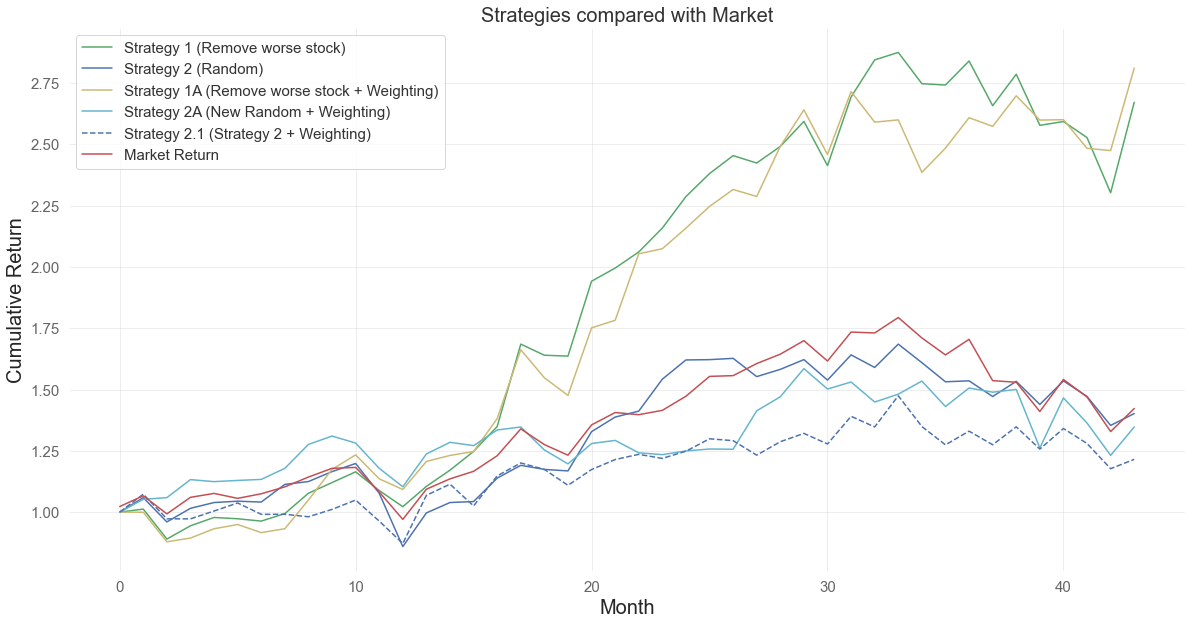

In [358]:
# Plot the market index and our portfolio performance, check if portfolio is better than market or not

''' Visualization '''

fig, ax = plt.subplots(figsize = (20, 10))
plt.plot((1 + s1_portfolio['Return']).cumprod()[:-2], color = 'g')
plt.plot((1 + s2_portfolio['Return']).cumprod()[:-2], color = 'b')
plt.plot((1 + s1a_portfolio['Return']).cumprod()[:-2], color = 'y')
plt.plot((1 + s2a_portfolio['Return']).cumprod()[:-2], color = 'c')
plt.plot((1 + s21_portfolio['Return']).cumprod()[:-2], color = 'b', linestyle='dashed')
plt.plot((1 + index_data['Return'][1:].reset_index(drop = True)).cumprod()[:-2], color = 'r')
plt.title('Strategies compared with Market', fontsize = 20)
plt.ylabel('Cumulative Return', fontsize = 20)
plt.xlabel('Month', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.legend(['Strategy 1 (Remove worse stock)', 'Strategy 2 (Random)', 'Strategy 1A (Remove worse stock + Weighting)', 'Strategy 2A (New Random + Weighting)', 'Strategy 2.1 (Strategy 2 + Weighting)', 'Market Return'], fontsize = 15)
#plt.subplots_adjust(top = 0.92, bottom = 0.1, left = 0.08, right = 0.94)
plt.show()

In [359]:
# Prepare for generate report
# Fix quantstats datetime compare issues
index_data.index = index_data.index.tz_localize(None)

In [360]:
index_data.head()

,Close,Return,Cumulative_Return
Date,,,
2019-02-01 05:00:00,1223.550049,0.026744,1.026744
2019-03-01 05:00:00,1251.560059,0.022892,1.050248
2019-04-01 04:00:00,1305.199951,0.042858,1.095260
2019-05-01 04:00:00,1215.020020,-0.069093,1.019586
2019-06-01 04:00:00,1297.459961,0.067851,1.088765


In [361]:
s1_export.head()

,Portfolio,Return
2019-03-01 05:00:00+00:00,"NVDA,AMT,TGT,COST,AAPL,MO,AVGO,ACN",0.000000
2019-04-01 04:00:00+00:00,"NVDA,COST,AAPL,AVGO,ACN,QCOM,DIS,F",0.012464
2019-05-01 04:00:00+00:00,"COST,AAPL,ACN,DIS,F,AMT,AIG,MDT",-0.120595
2019-06-01 04:00:00+00:00,"COST,AAPL,DIS,F,MDT,NVDA,TSLA,GM",0.060646
2019-07-01 04:00:00+00:00,"COST,AAPL,MDT,TSLA,GM,UPS,SBUX,GOOG",0.036076


In [362]:
# Export html report of above 5 strategies using Quantstats library
# Strategies: s1 / s1a / s2 / s2a / s21: change to ??_export.copy() below to generate different reports
qs_src = s1_export.copy() # Prevent modify the original data
qs_src.index = qs_src.index.tz_localize(None)
qs.reports.html(qs_src['Return'], benchmark=index_data['Return'][1:], title='Strategy vs '+stock_index, output='', download_filename='portfolio_vs_market.html')


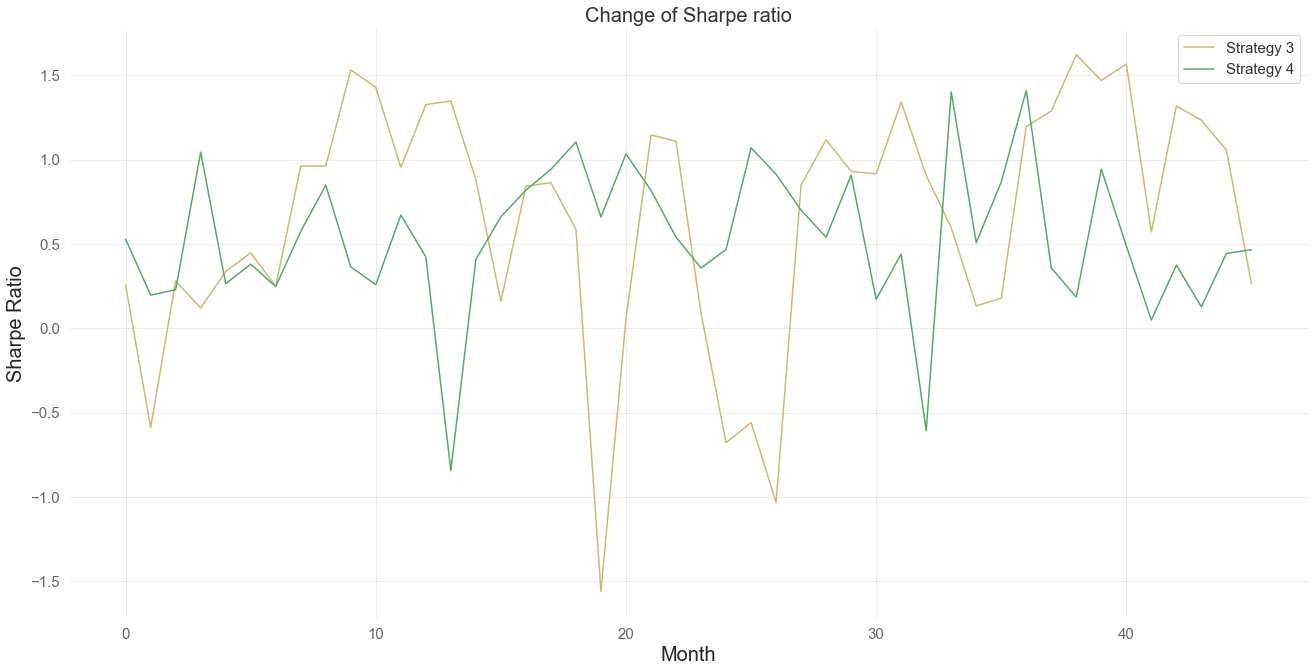

In [363]:
#######################################################
# Below all codes are for DEBUG, no need to run!!!
# For Strategy 3 and 4 - Plot Sharpe ratio 
fig, ax = plt.subplots(figsize = (20, 10))
plt.plot((s1a_portfolio['sharpe']), color = 'y')
plt.plot((s2a_portfolio['sharpe']), color = 'g')
#plt.plot((1 + dji_index['Return'][2:].reset_index(drop = True)).cumprod(), color = 'r')
plt.title('Change of Sharpe ratio', fontsize = 20)
plt.ylabel('Sharpe Ratio', fontsize = 20)
plt.xlabel('Month', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.legend(['Strategy 3', 'Strategy 4'], fontsize = 15)
plt.subplots_adjust(top = 0.92, bottom = 0.1, left = 0.08, right = 0.94)
plt.show()

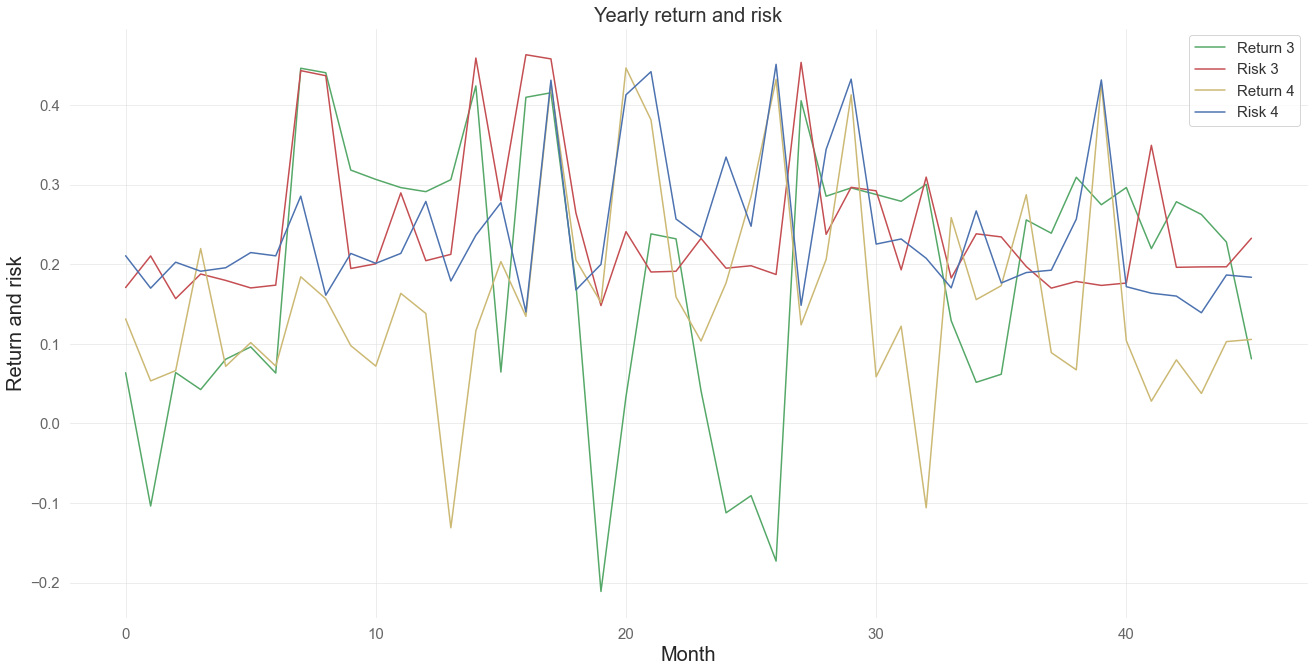

In [364]:
# For Strategy 3 and 4 - Plot Return and Risk
fig, ax = plt.subplots(figsize = (20, 10))
plt.plot((s1a_portfolio['yr_return']), color = 'g')
plt.plot((s1a_portfolio['yr_risk']), color = 'r')
plt.plot((s2a_portfolio['yr_return']), color = 'y')
plt.plot((s2a_portfolio['yr_risk']), color = 'b')
#plt.plot((1 + dji_index['Return'][2:].reset_index(drop = True)).cumprod(), color = 'r')
plt.title('Yearly return and risk', fontsize = 20)
plt.ylabel('Return and risk', fontsize = 20)
plt.xlabel('Month', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.legend(['Return 3','Risk 3', 'Return 4', 'Risk 4'], fontsize = 15)
plt.subplots_adjust(top = 0.92, bottom = 0.1, left = 0.08, right = 0.94)
plt.show()